In [2]:
from TejToolAPI.TejToolAPI import *
tejapi.ApiConfig.api_base="http://10.10.10.66"
tejapi.ApiConfig.api_key = "3jUCETU2KiPwGJeyETYOQd1TCoDoxX"
tejapi.ApiConfig.ignoretz = True
import numpy as np
import dask.dataframe as dd
import dask
import datetime

In [2]:
with open('items.txt', 'r') as file:
    all_tickers = file.read()
    file.close()
all_tickers = all_tickers.replace('\n', ',').replace('', '').split(',')

## 測試 get_trading_calendar
- 原本的方法
- 使用 dask 進行優化 <br>
結論: dask比較好


In [78]:
def get_trading_calendar_dask(tickers, **kwargs):
    # Setting default value of the corresponding parameters
    start = kwargs.get('start', para.default_start)
    end = kwargs.get('end', para.default_end)
    npartitions = kwargs.get('npartitions',  para.npartitions_local)

    # 
    trading_calendar = pd.DataFrame()
    def get_data(tickers):
        # trading calendar
        data = tejapi.get('TWN/APIPRCD',
                        coid = tickers,
                        paginate = True,
                        chinese_column_name=False,
                        mdate = {'gte':start,'lte':end},
                        opts = {'columns':['coid','mdate'], 'sort':{'coid.asc', 'mdate.asc'}})
        if len(data)>1:
            return data
        else:
            return pd.DataFrame({'coid': pd.Series(dtype='object'), 'mdate': pd.Series(dtype='datetime64[ns]')})
    
    # Define the meta of the dataframe
    meta = pd.DataFrame({'coid': pd.Series(dtype='object'), 'mdate': pd.Series(dtype='datetime64[ns]')})

    # Calculate the number of tickers in each partition. 
    ticker_partitions = get_partition_group(tickers = tickers, npartitions= npartitions)

    # Submit jobs to the parallel cores
    trading_calendar = dd.from_delayed([dask.delayed(get_data)(tickers[(i-1)*npartitions:i*npartitions]) for i in range(1, ticker_partitions)], meta = meta)

    # If ticker smaller than defaulted partitions, then transform it into defaulted partitions
    if trading_calendar.npartitions < 12:
        trading_calendar = trading_calendar.repartition(npartitions=npartitions)

    return trading_calendar

def get_trading_calendar_org(tickers, **kwargs):
    # Setting default value of the corresponding parameters
    start = kwargs.get('start', para.default_start)
    end = kwargs.get('end', para.default_end)
    npartitions = kwargs.get('npartitions',  para.npartitions_local)

    # 
    trading_calendar = pd.DataFrame()
    def get_data(tickers):
        # trading calendar
        data = tejapi.get('TWN/APIPRCD',
                        coid = tickers,
                        paginate = True,
                        chinese_column_name=False,
                        mdate = {'gte':start,'lte':end},
                        opts = {'columns':['coid','mdate'], 'sort':{'coid.asc', 'mdate.asc'}})
        if len(data)>1:
            return data
        else:
            return pd.DataFrame({'coid': pd.Series(dtype='object'), 'mdate': pd.Series(dtype='datetime64[ns]')})
    
    meta = pd.DataFrame({'coid': pd.Series(dtype='object'), 'mdate': pd.Series(dtype='datetime64[ns]')})
    trading_calendar = dd.from_delayed([dask.delayed(get_data)(ticker) for ticker in tickers], meta = meta)
    trading_calendar = trading_calendar.repartition(npartitions=npartitions)

    return trading_calendar



In [269]:
result = get_trading_calendar_org(tickers=all_tickers, start = '2008-01-01')

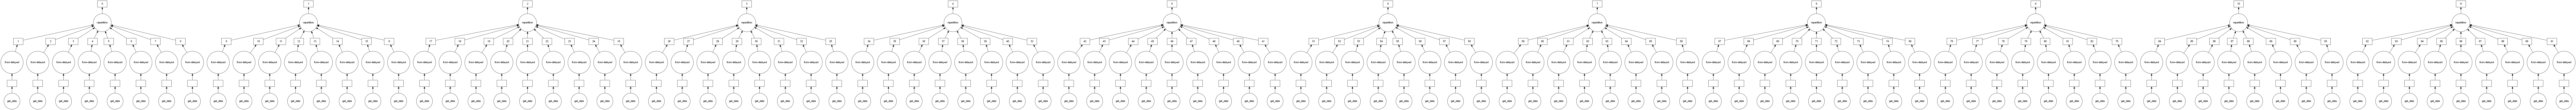

In [72]:
result.visualize()

In [270]:
data_org = result.compute()
data_org

coid      mdate
0     1101 2023-06-07
1     1101 2023-06-06
2     1101 2023-06-05
3     1101 2023-06-02
4     1101 2023-06-01
...    ...        ...
3793  9962 2008-01-08
3794  9962 2008-01-07
3795  9962 2008-01-04
3796  9962 2008-01-03
3797  9962 2008-01-02

[5758309 rows x 2 columns]

In [271]:
result_dask = get_trading_calendar_dask(tickers=all_tickers, start = '2008-01-01')

In [272]:
result_dask

Dask DataFrame Structure:
                   coid           mdate
npartitions=159                        
                 object  datetime64[ns]
                    ...             ...
...                 ...             ...
                    ...             ...
                    ...             ...
Dask Name: from-delayed, 318 tasks

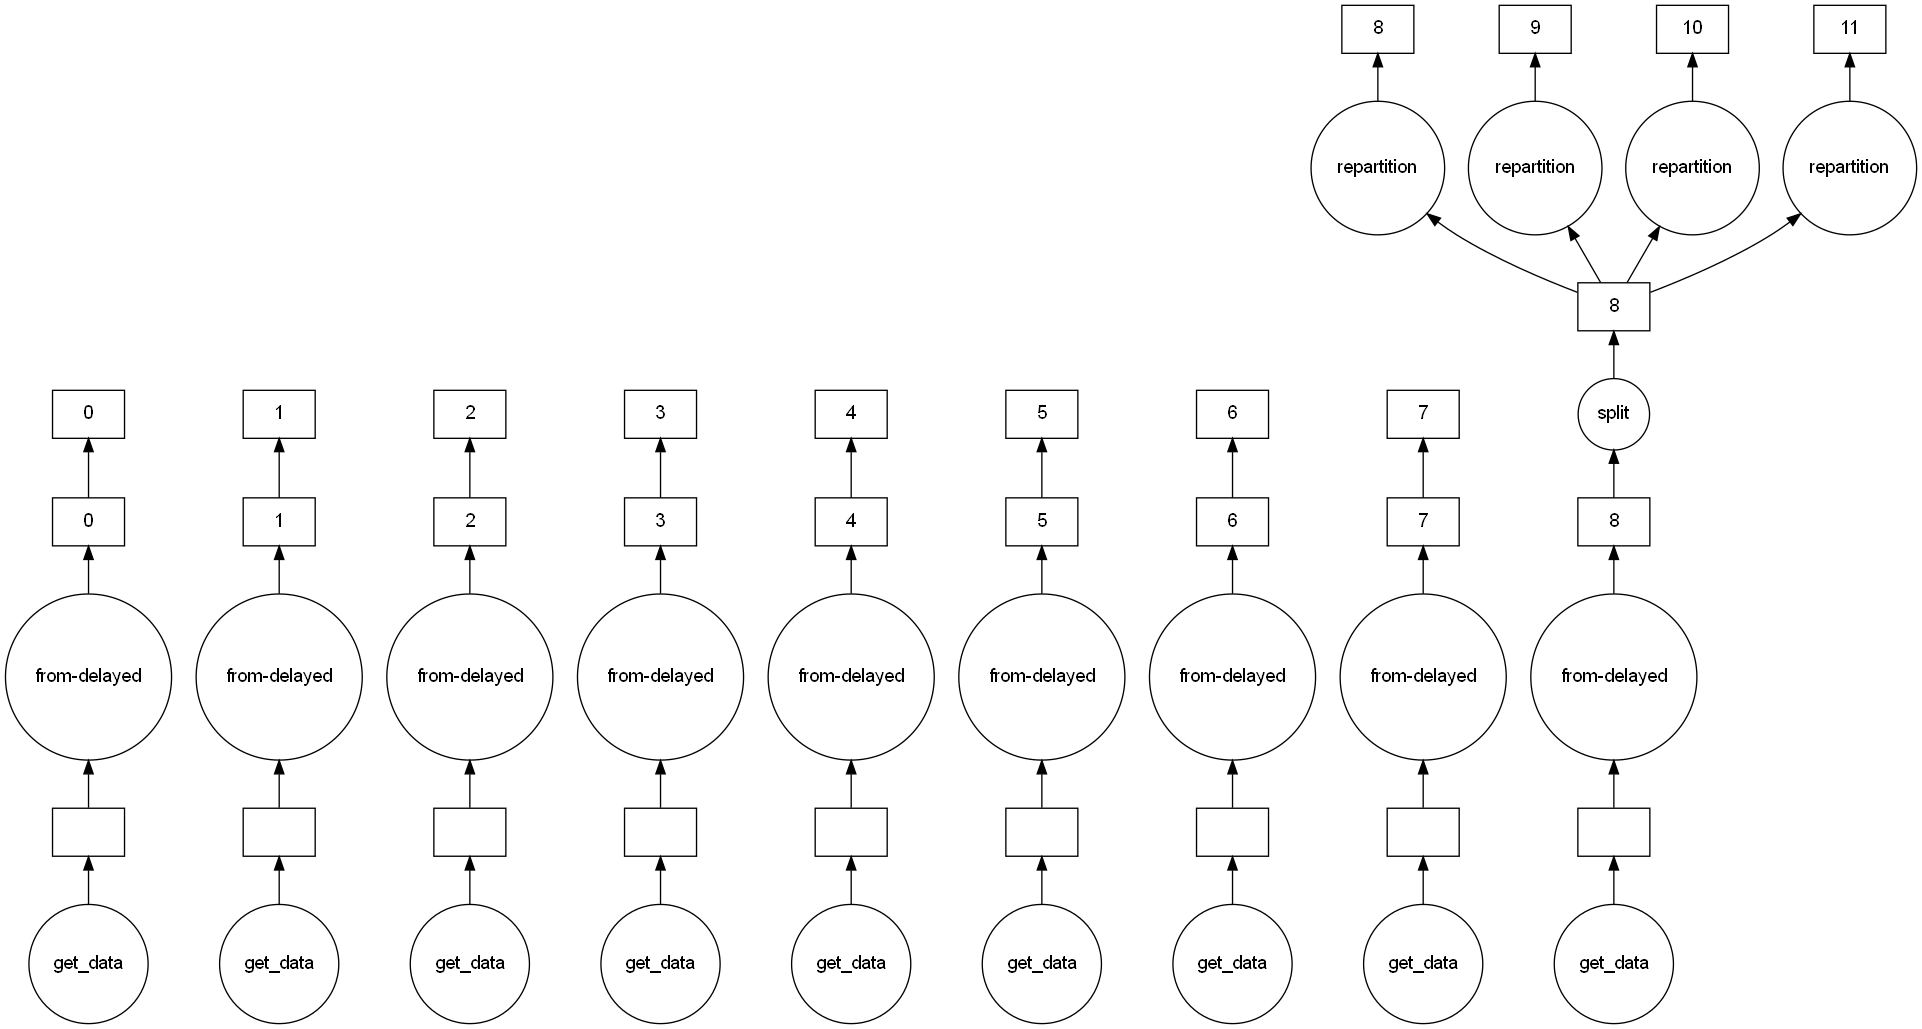

In [80]:
result_dask.visualize()

In [273]:
data_dask = result_dask.compute()
data_dask

coid      mdate
None                  
0      1215 2023-06-07
1      1215 2023-06-06
2      1215 2023-06-05
3      1215 2023-06-02
4      1215 2023-06-01
...     ...        ...
22720  9950 2008-01-08
22721  9950 2008-01-07
22722  9950 2008-01-04
22723  9950 2008-01-03
22724  9950 2008-01-02

[5758309 rows x 2 columns]

## 測試 get_trading_data
- 原本的方法
- 使用 dask 進行優化<br>
結論: dask 比較好

In [107]:
def get_trading_data_dask(table, tickers, columns = [], **kwargs):
    # Setting default value of the corresponding parameters
    start = kwargs.get('start', para.default_start)
    end = kwargs.get('end', para.default_end)
    npartitions = kwargs.get('npartitions',  para.npartitions_local)

    # 自動補上 coid, mdate
    columns += ['coid', 'mdate']
    columns = list(set(columns))

    def get_data(table, tickers, columns, start, end):
        data = tejapi.get(table,
                        coid = tickers,
                        paginate = True,
                        chinese_column_name=False,
                        mdate = {'gte':start,'lte':end},
                        opts = {'columns':columns, 'sort':{'coid.desc', 'mdate.asc'}})
        return data
    
    # Define the meta of the dataframe
    meta = get_data(table = table, tickers = tickers[0], columns=columns, start = start, end =end)

    # Calculate the number of tickers in each partition.
    ticker_partitions = get_partition_group(tickers=tickers, npartitions=npartitions)
    
    # Submit jobs to the parallel cores
    data_sets = dd.from_delayed([dask.delayed(get_data)(table, tickers[(i-1)*npartitions:i*npartitions], columns, start, end) for i in range(1, ticker_partitions)], meta = meta)
    
    # If ticker smaller than defaulted partitions, then transform it into defaulted partitions
    if data_sets.npartitions < 12:
        data_sets = data_sets.repartition(npartitions=npartitions)


    return data_sets

def get_trading_data_org(table, tickers, columns = [], **kwargs):
    # Setting default value of the corresponding parameters
    start = kwargs.get('start', para.default_start)
    end = kwargs.get('end', para.default_end)
    npartitions = kwargs.get('npartitions',  para.npartitions_local)

    # 自動補上 coid, mdate
    columns += ['coid', 'mdate']
    columns = list(set(columns))

    data_sets = tejapi.get(table,
                    coid = tickers,
                    paginate = True,
                    chinese_column_name=False,
                    mdate = {'gte':start,'lte':end},
                    opts = {'columns':columns, 'sort':{'coid.desc', 'mdate.asc'}})
    
    data_sets = dd.from_pandas(data_sets, npartitions=npartitions)

    return data_sets

In [111]:
data_org = get_trading_data_org('TWN/APIPRCD',tickers=all_tickers[:500], columns=['roi'], start = '2008-01-01')

In [117]:
data_org.visualize()

AttributeError: 'DataFrame' object has no attribute 'visualize'

In [120]:
data_org 

roi  coid      mdate
None                            
0        6.5789  2637 2010-12-01
1       -2.8395  2637 2010-12-02
2        1.6518  2637 2010-12-03
3       -1.1250  2637 2010-12-06
4        0.6321  2637 2010-12-07
...         ...   ...        ...
1776245 -0.3958  1101 2023-06-01
1776246  2.1192  1101 2023-06-02
1776247  0.7782  1101 2023-06-05
1776248 -0.1287  1101 2023-06-06
1776249  0.0000  1101 2023-06-07

[1776250 rows x 3 columns]

In [268]:
data_dask = get_trading_data_dask('TWN/APIPRCD',tickers=all_tickers[:500], columns=['roi'], start = '2008-01-01')
data_dask

Dask DataFrame Structure:
                    roi    coid           mdate
npartitions=42                                 
                float64  object  datetime64[ns]
                    ...     ...             ...
...                 ...     ...             ...
                    ...     ...             ...
                    ...     ...             ...
Dask Name: from-delayed, 84 tasks

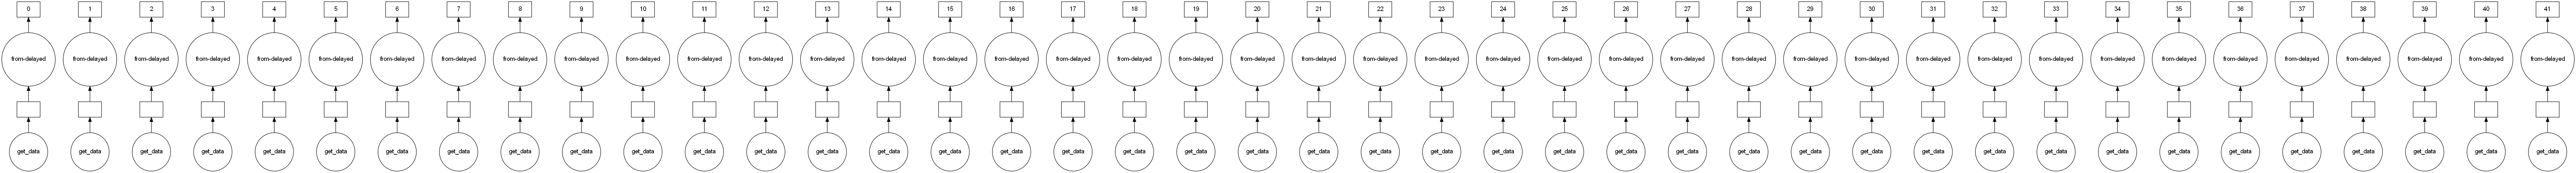

In [124]:
data_dask.visualize()

In [125]:
data_dask = data_dask.compute()
data_dask

roi  coid      mdate
None                          
0     -0.6757  1215 2008-01-02
1      3.4014  1215 2008-01-03
2      0.6579  1215 2008-01-04
3     -3.9216  1215 2008-01-07
4     -0.6803  1215 2008-01-08
...       ...   ...        ...
23006  0.0000  2616 2023-06-01
23007 -0.3072  2616 2023-06-02
23008  0.3082  2616 2023-06-05
23009  0.1536  2616 2023-06-06
23010  0.1534  2616 2023-06-07

[1776250 rows x 3 columns]

## 測試 generate_multicalendars
- 使用 dask 優化
- 原本的方法 <br>
結論: dask 比較好

In [244]:

def generate_multicalendars_dask(tickers, **kwargs):
    # Setting defualt value of the parameters
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    npartitions = kwargs.get('npartitions', 12)


    def get_daily_calendar(tickers:list):
        def get_data(ticker):
            cal = pd.date_range(start=start, end=end, freq='D')
            coid = [str(ticker)]*len(cal)
            return pd.DataFrame({'coid':coid, 'all_dates': cal})
        
        # Multi-ticker method
        if len(tickers) > 1:
            data_sets = pd.DataFrame()
            for ticker in tickers:
                data = get_data(ticker = ticker)
                data_sets = pd.concat([data_sets, data])
                
        # Single ticker mehtod
        else:
            data_sets = get_data(ticker = tickers)

        return data_sets

    # Define the meta for the dataframe
    meta = pd.DataFrame({'coid': pd.Series(dtype='object'), 'all_dates': pd.Series(dtype='datetime64[ns]')})
    
    # Calculate the number of tickers in each partition. 
    ticker_partitions = get_partition_group(tickers=tickers, npartitions=npartitions)

    # Submit jobs to the parallel cores
    fin_calendar = dd.from_delayed([dask.delayed(get_daily_calendar)(tickers[(i-1)*npartitions:i*npartitions]) for i in range(1, ticker_partitions)], meta = meta)
    
    # If ticker smaller than defaulted partitions, then transform it into defaulted partitions
    if fin_calendar.npartitions < 12:
        fin_calendar = fin_calendar.repartition(npartitions=npartitions)

    return fin_calendar

def generate_multicalendars_org(tickers, **kwargs):
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    npartitions = kwargs.get('npartitions', 12)
    def get_daily_calendar(ticker):
        cal = pd.date_range(start=start, end=end, freq='D')
        coid = [str(ticker)]*len(cal)
        return pd.DataFrame({'coid':coid, 'all_dates': cal})
    
    # Define the meta for the dataframe
    meta = pd.DataFrame({'coid': pd.Series(dtype='object'), 'all_dates': pd.Series(dtype='datetime64[ns]')})

    # Submit jobs to the paralell cores
    D_cal = dd.from_delayed([dask.delayed(get_daily_calendar)(ticker) for ticker in tickers], meta = meta)
    D_cal = D_cal.repartition(npartitions=npartitions)
    
    return D_cal

In [3]:
data = para.dask_mpf.generate_multicalendars(tickers=['2881', '1101','9958','2330'], start = '2008-01-01')

In [5]:
data.compute()

coid  all_dates
0     2881 2008-01-01
1     2881 2008-01-02
2     2881 2008-01-03
3     2881 2008-01-04
4     2881 2008-01-05
...    ...        ...
5633  2330 2023-06-04
5634  2330 2023-06-05
5635  2330 2023-06-06
5636  2330 2023-06-07
5637  2330 2023-06-08

[22552 rows x 2 columns]

In [237]:
fin_calendar = generate_multicalendars_org(tickers=all_tickers, start = '2008-01-01') 

In [238]:
fin_calendar.visualize()

KeyboardInterrupt: 

In [239]:
fin_calendar = fin_calendar.compute()
fin_calendar

coid  all_dates
0     1101 2008-01-01
1     1101 2008-01-02
2     1101 2008-01-03
3     1101 2008-01-04
4     1101 2008-01-05
...    ...        ...
5633       2023-06-04
5634       2023-06-05
5635       2023-06-06
5636       2023-06-07
5637       2023-06-08

[10729114 rows x 2 columns]

In [266]:
fin_calendar_dask = generate_multicalendars_dask(tickers=all_tickers, start = '2008-01-01') 
fin_calendar_dask

Dask DataFrame Structure:
                   coid       all_dates
npartitions=159                        
                 object  datetime64[ns]
                    ...             ...
...                 ...             ...
                    ...             ...
                    ...             ...
Dask Name: from-delayed, 318 tasks

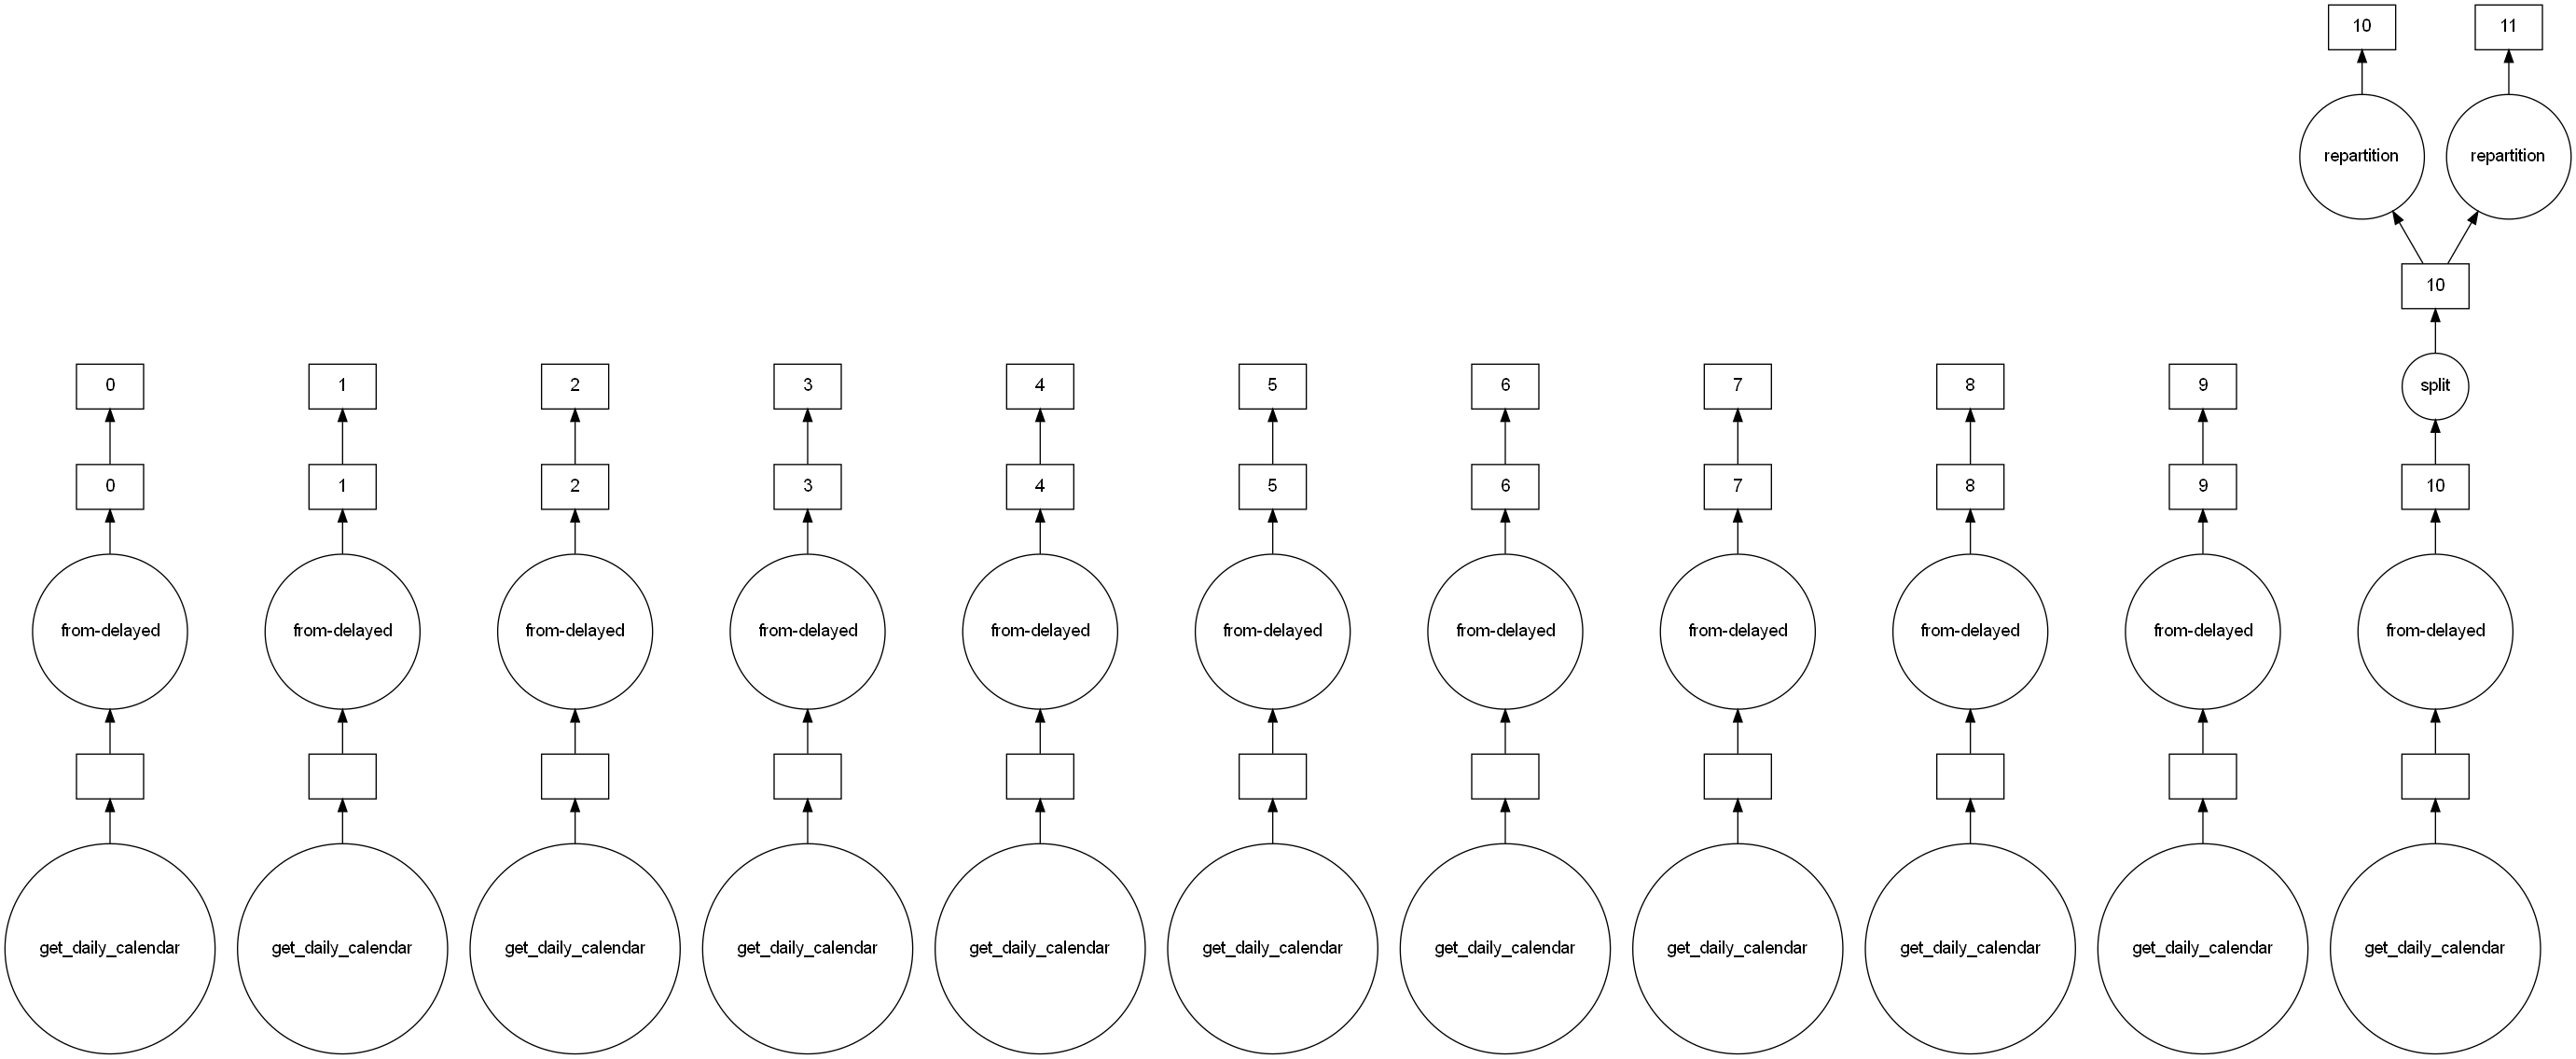

In [241]:
fin_calendar_dask.visualize()

In [267]:
fin_calendar_dask = fin_calendar_dask.compute()
fin_calendar_dask

coid  all_dates
0     1101 2008-01-01
1     1101 2008-01-02
2     1101 2008-01-03
3     1101 2008-01-04
4     1101 2008-01-05
...    ...        ...
5633       2023-06-04
5634       2023-06-05
5635       2023-06-06
5636       2023-06-07
5637       2023-06-08

[10729114 rows x 2 columns]

## 測試 get_alternative_data
- 原本的方法
- 使用 dask 進行優化<br>
結論: 原本的方法比較好

In [259]:
def get_data(table, tickers, columns, start, end):
    # alternative data
    data_sets = tejapi.get(table,
                    coid = tickers,
                    paginate = True,
                    chinese_column_name=False,
                    mdate = {'gte':start,'lte':end},
                    opts = {'columns':columns, 'sort':{'coid.asc', 'mdate.asc'}})
    data_sets = data_sets.drop(columns=['mdate'])

    # 營業日
    days = generate_multicalendars_dask(tickers, start = start, end = end)

    # Tranfer to daily basis
    if table == 'TWN/APISALE':
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['annd_s', 'coid'])
    else:
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['edate1', 'coid'])
    
    del days
    gc.collect()

    return data_sets.compute()

def get_alternative_data_dask(table, tickers=[], columns = [], **kwargs):
    # Setting defualt value of the parameters
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    npartitions = kwargs.get('npartitions', 12)

    # 自動補上 coid, mdate, 發布日
    if table == 'TWN/APISALE':
        # 月營收
        columns += ['coid', 'mdate','annd_s']
        columns = list(set(columns))

    else:
        # 集保資料 
        columns += ['coid','mdate','edate1']
        columns = list(set(columns))

    # 營業日
    days = generate_multicalendars_dask(tickers, start = start, end = end)

    def get_data(table, tickers, columns, start, end):
        # alternative data
        data_sets = tejapi.get(table,
                        coid = tickers,
                        paginate = True,
                        chinese_column_name=False,
                        mdate = {'gte':start,'lte':end},
                        opts = {'columns':columns, 'sort':{'coid.desc', 'mdate.desc'}})
        data_sets = data_sets.drop(columns=['mdate'])

        # # 營業日
        # days = generate_multicalendars_dask(tickers, start = start, end = end)

        # # Tranfer to daily basis
        # if table == 'TWN/APISALE':
        #     data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['annd_s', 'coid'])
        # else:
        #     data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['edate1', 'coid'])
        
        # del days
        # gc.collect()

        # data_sets = data_sets.groupby('coid', group_keys = False).apply(fillna_multicolumns, meta = data_sets)
        # return data_sets.compute()
        return data_sets
    
    # Define the meta of the dataframe
    meta = get_data(table = table, tickers = tickers[0], columns=columns, start = start, end =end)

    # Calculate the number of tickers in each partition. 
    ticker_partitions = get_partition_group(tickers=tickers, npartitions=npartitions)
    
    #
    data_sets = dd.from_delayed([dask.delayed(get_data)(table, tickers[(i-1)*npartitions:i*npartitions], columns, start, end) for i in range(1, ticker_partitions)], meta = meta)

    if table == 'TWN/APISALE':
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['annd_s', 'coid'])
    else:
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['edate1', 'coid'])
    
    data_sets = data_sets.groupby('coid', group_keys = False).apply(fillna_multicolumns, meta = data_sets)

    return data_sets

def get_alternative_data_org(table, tickers=[], columns = [], **kwargs):
    # Setting defualt value of the parameters
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    npartitions = kwargs.get('npartitions', 12)

    # 自動補上 coid, mdate, 發布日
    if table == 'TWN/APISALE':
        # 月營收
        columns += ['coid', 'mdate','annd_s']
        columns = list(set(columns))

    else:
        # 集保資料 
        columns += ['coid','mdate','edate1']
        columns = list(set(columns))
    
    # 營業日
    days = generate_multicalendars_dask(tickers, start = start, end = end)

    # alternative data
    data_sets = tejapi.get(table,
                    coid = tickers,
                    paginate = True,
                    chinese_column_name=False,
                    mdate = {'gte':start,'lte':end},
                    opts = {'columns':columns, 'sort':{'coid.asc', 'mdate.asc','annd_s.asc'}})
    data_sets = data_sets.drop(columns=['mdate'])
    
    if table == 'TWN/APISALE':
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['annd_s', 'coid'])
    else:
        data_sets = dd.merge(days, data_sets, how='left', left_on = ['all_dates', 'coid'], right_on=['edate1', 'coid'])
    
    # Delete days 
    del days
    gc.collect()


    data_sets = data_sets.groupby('coid', group_keys = False).apply(fillna_multicolumns, meta = data_sets)

    return data_sets

def fillna_multicolumns(df):
    return df.fillna(method = 'ffill')


In [262]:
data_org = get_alternative_data_org(table = 'TWN/APISALE', tickers= all_tickers, columns=['d0001'],start = '2008-01-01')

In [232]:
data_org.visualize()

In [263]:
data_org = data_org.compute()
data_org

coid  all_dates     annd_s     d0001
16914  1438 2008-01-01        NaT       NaN
16915  1438 2008-01-02        NaT       NaN
16916  1438 2008-01-03        NaT       NaN
16917  1438 2008-01-04        NaT       NaN
16918  1438 2008-01-05        NaT       NaN
...     ...        ...        ...       ...
56375  6118 2023-06-04 2023-05-10  661403.0
56376  6118 2023-06-05 2023-05-10  661403.0
56377  6118 2023-06-06 2023-05-10  661403.0
56378  6118 2023-06-07 2023-05-10  661403.0
56379  6118 2023-06-08 2023-05-10  661403.0

[10729119 rows x 4 columns]

In [264]:
data_dask = get_alternative_data_dask(table = 'TWN/APISALE', tickers= all_tickers, columns=['d0001'], start = '2008-01-01')

In [252]:
data_dask

Dask DataFrame Structure:
                  coid       all_dates          annd_s    d0001
npartitions=42                                                 
                object  datetime64[ns]  datetime64[ns]  float64
                   ...             ...             ...      ...
...                ...             ...             ...      ...
                   ...             ...             ...      ...
                   ...             ...             ...      ...
Dask Name: fillna_multicolumns, 1014 tasks

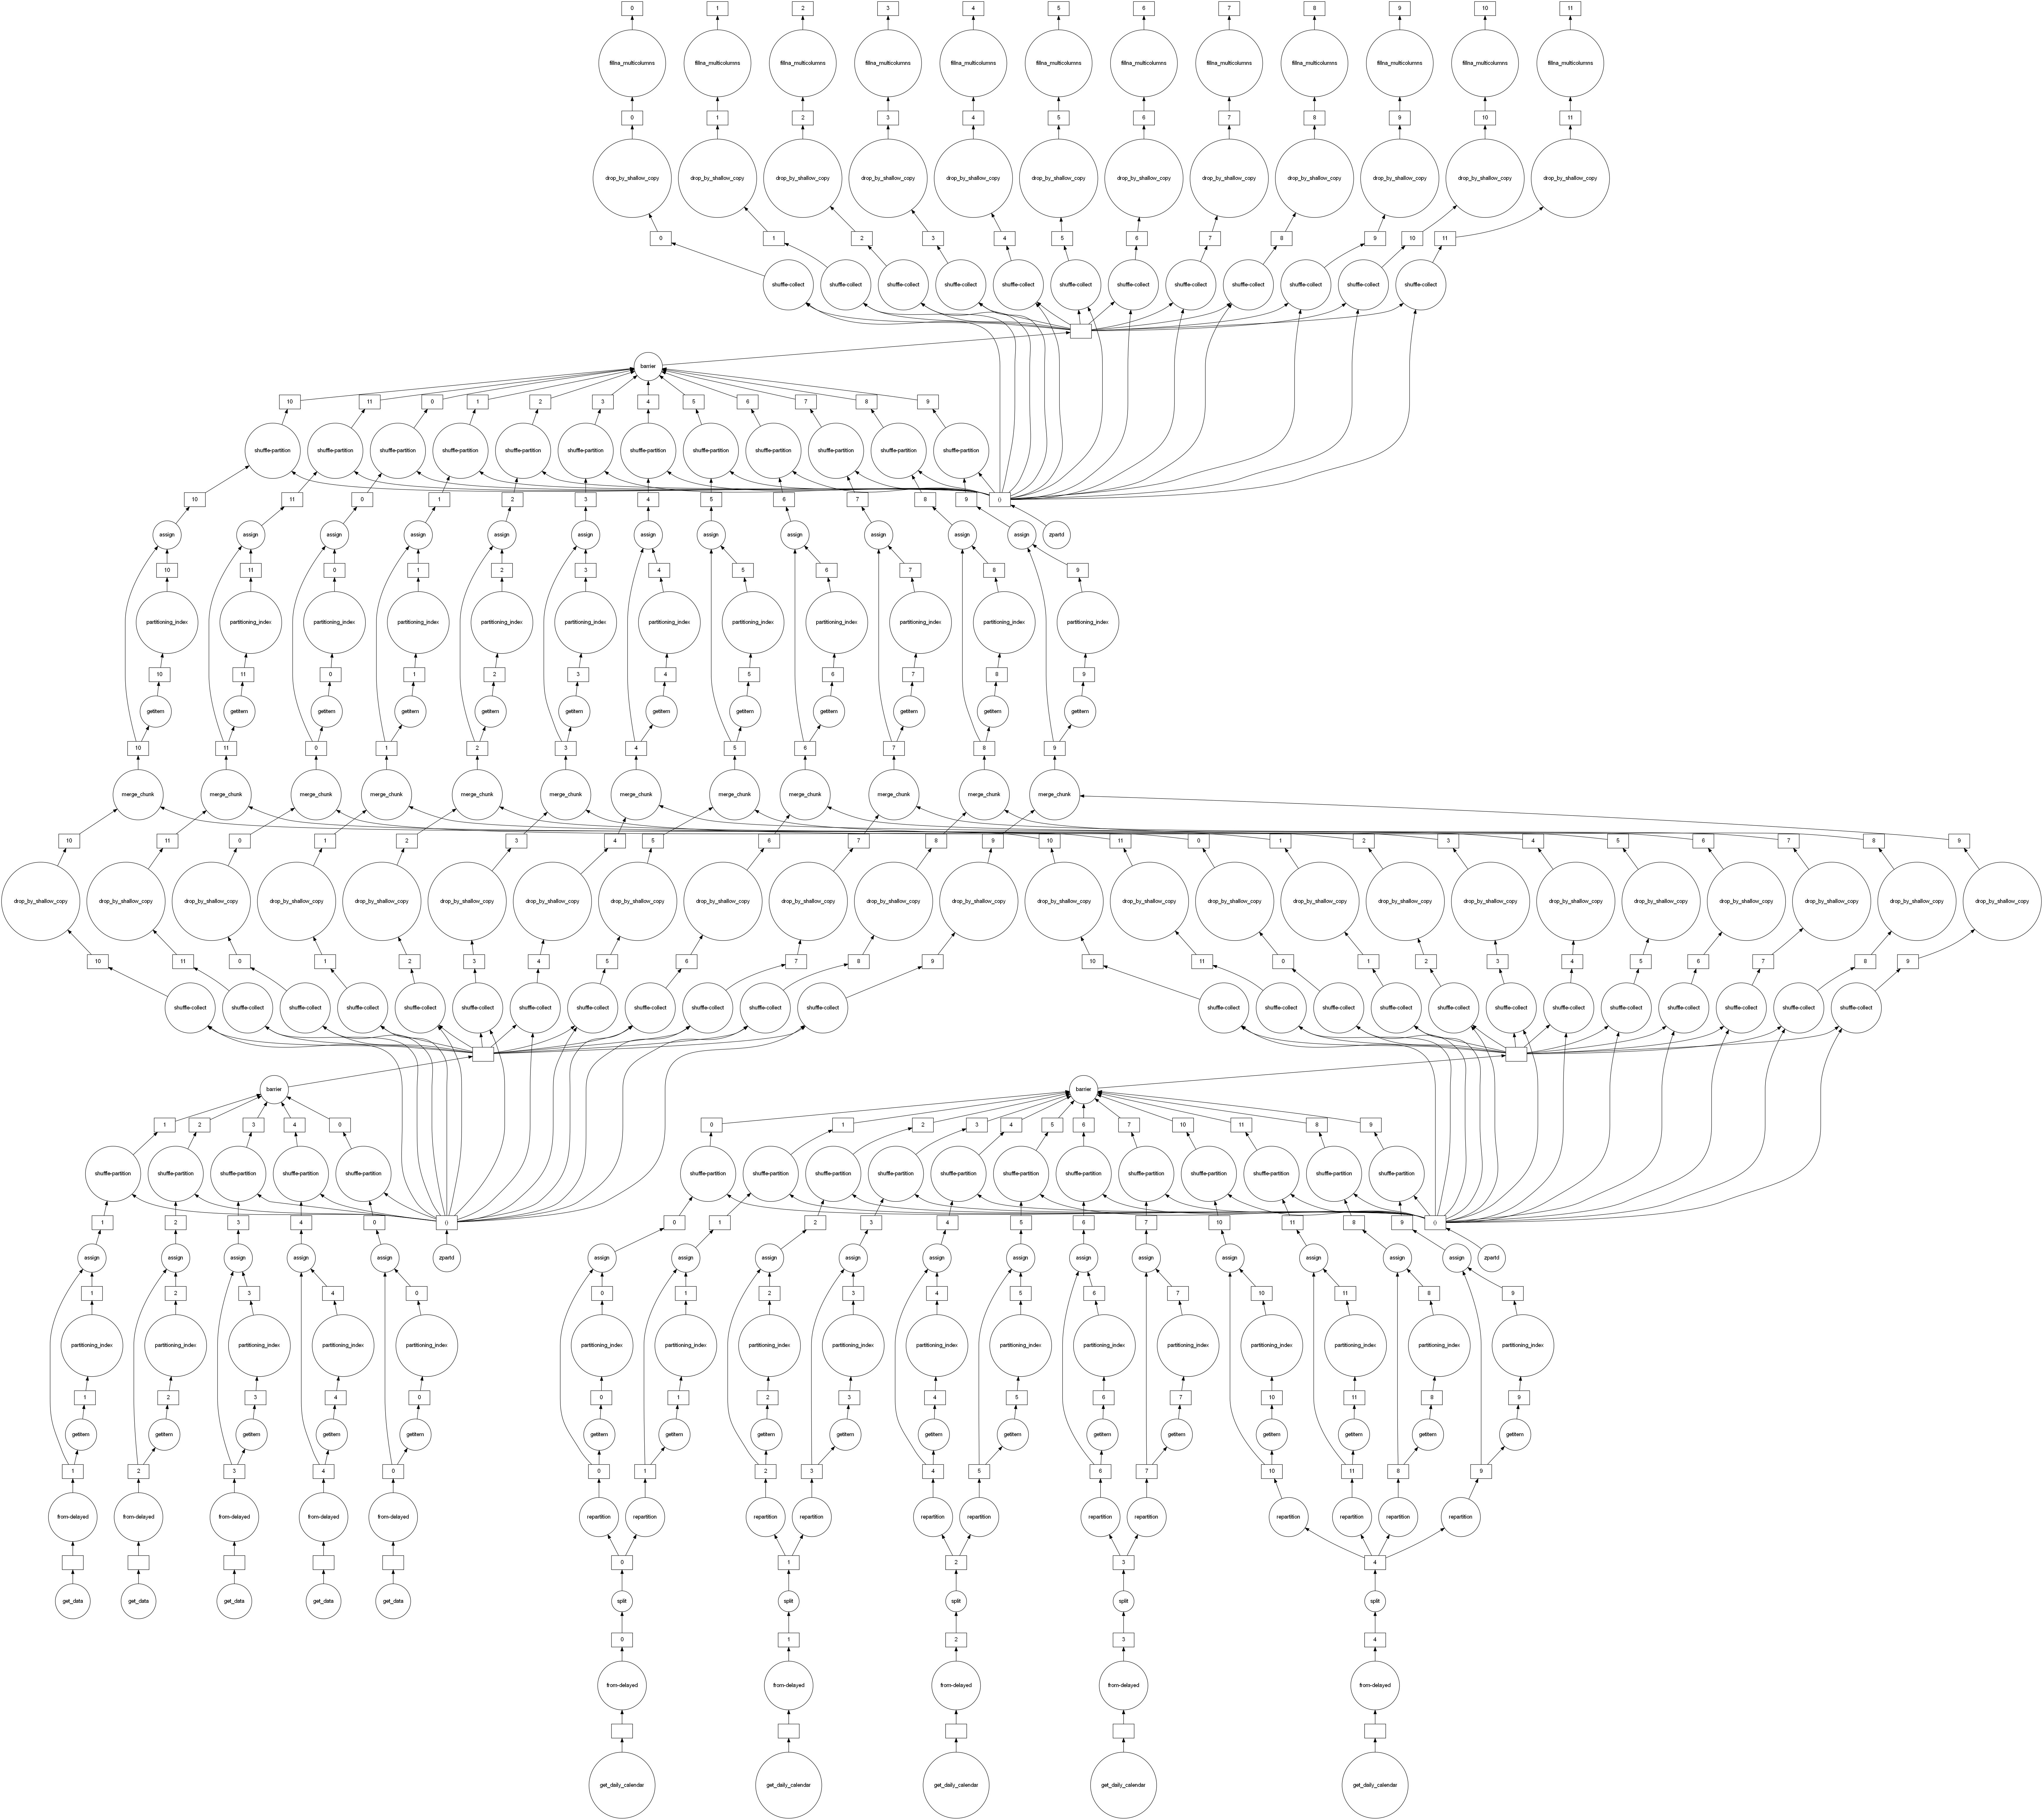

In [229]:
data_dask.visualize()

In [265]:
data_dask = data_dask.compute()
data_dask

coid  all_dates     annd_s     d0001
3094   1438 2008-09-06        NaT       NaN
3094   1438 2016-07-31 2015-11-09      23.0
3094   1438 2021-05-15 2014-05-08       0.0
3094   1438 2011-03-12 2014-05-08       0.0
3094   1438 2022-02-05 2015-03-02   11687.0
...     ...        ...        ...       ...
50222  6194 2009-05-18 2023-04-06  155600.0
50223  6194 2009-05-29 2023-04-06  155600.0
50224  6194 2009-12-15 2023-04-06  155600.0
50225  6194 2010-05-25 2023-04-06  155600.0
50226  6194 2010-08-18 2023-04-06  155600.0

[10729119 rows x 4 columns]

## 測試 get_fin_data
- 原本的方法
- 使用 dask 進行優化<br>
結論: dask 比較快

In [5]:
import multiprocessing

npartitions_local = multiprocessing.cpu_count()

default_start = '2013-01-01'
default_end = datetime.datetime.now().date().strftime('%Y-%m-%d')

def get_fin_data_dask(table, tickers, columns=[], **kwargs):
    start = kwargs.get('start', default_start)
    end = kwargs.get('end', default_end)
    fin_type = kwargs.get('fin_type', ['A', 'Q', 'TTM'])
    # transfer_to_chinese = False
    npartitions = kwargs.get('npartitions', npartitions_local)

    # transfer fin_ann_date to daily basis
    # days = generate_multicalendars(tickers, start = start, end = end)
    
    # 將需要的 column 選出
    columns += ['coid', 'mdate', 'annd', 'no', 'key3']
    columns = list(set(columns))

    # get all data
    def get_data(table, tickers, columns, start, end, fin_type):
        data_sets = tejapi.get(table,
                        coid=tickers,
                        paginate=True,
                        chinese_column_name=False,
                        mdate={'gte': start, 'lte': end},
                        opts={'columns': columns, 'sort':{'coid.desc', 'mdate.asc', 'annd.asc', 'no.asc'}})
                
        # select certain fin_type
        data_sets = para.dask_mpf.get_certain_fin_type(data_sets, fin_type)

        # parallel fin_type to columns 
        data_sets = para.dask_mpf.fin_pivot(data_sets, remain_keys=['coid', 'mdate', 'no', 'annd'])

        return data_sets
    
    # Define the meta of the dataframe
    meta = get_data(table = table, tickers = tickers[0], columns = columns, start = start, end =end, fin_type= fin_type)

    # Calculate the number of tickers in each partition.
    ticker_partitions = para.dask_mpf.get_partition_group(tickers=tickers, npartitions=npartitions)
    
    # Submit jobs to the parallel cores
    data_sets = dd.from_delayed([dask.delayed(get_data)(table=table, tickers = tickers[(i-1)*npartitions:i*npartitions], columns = columns, start = start, end = end, fin_type = fin_type) for i in range(1, ticker_partitions)], meta = meta)
    
    # If ticker smaller than defaulted partitions, then transform it into defaulted partitions
    if data_sets.npartitions < 12:
        data_sets = data_sets.repartition(npartitions=npartitions)

    return data_sets
    
def get_fin_data_org(table, tickers, columns=[], **kwargs):
    start = kwargs.get('start', default_start)
    end = kwargs.get('end', default_end)
    fin_type = kwargs.get('fin_type', ['A', 'Q', 'TTM'])
    # transfer_to_chinese = False
    npartitions = kwargs.get('npartitions', npartitions_local)

    # transfer fin_ann_date to daily basis
    # days = generate_multicalendars(tickers, start = start, end = end)
    
    # 將需要的 column 選出
    columns += ['coid', 'mdate', 'annd', 'no', 'key3']
    columns = list(set(columns))

    # get all data
    data_sets = tejapi.get(table,
                    coid=tickers,
                    paginate=True,
                    chinese_column_name=False,
                    mdate={'gte': start, 'lte': end},
                    opts={'columns': columns, 'sort':{'coid.desc', 'mdate.asc', 'annd.asc', 'no.asc'}})
            
    # select certain fin_type
    data_sets = para.dask_mpf.get_certain_fin_type(data_sets, fin_type)

    # parallel fin_type to columns 
    data_sets = para.dask_mpf.fin_pivot(data_sets, remain_keys=['coid', 'mdate', 'no', 'annd'])

    return data_sets

In [15]:
data_org = get_fin_data_org(table='TWN/AFESTM1', tickers=all_tickers, columns=['r405'], start = '2008-01-01')
data_org

no       annd      mdate  r405_A  coid  r405_Q  r405_TTM
0      001 2013-05-02 2013-03-01  289.82  9962     NaN   1295.28
1      001 2013-08-09 2013-06-01     NaN  9962     NaN       NaN
2      001 2014-03-05 2013-12-01     NaN  9962     NaN       NaN
3      001 2014-05-05 2014-03-01  -69.61  9962  -69.61    -80.12
4      001 2014-10-31 2014-09-01     NaN  9962     NaN       NaN
...    ...        ...        ...     ...   ...     ...       ...
34221  001 2022-05-10 2022-03-01  -77.04  1101  -77.04    -35.10
34222  001 2022-08-10 2022-06-01 -100.70  1101 -111.37    -67.30
34223  001 2022-11-10 2022-09-01  -90.43  1101  -61.33    -72.30
34224  001 2023-02-24 2022-12-01  -80.39  1101  -47.54    -80.39
34225  001 2023-05-11 2023-03-01   17.41  1101   17.41    -76.50

[34226 rows x 7 columns]

In [17]:
data_dask = get_fin_data_dask(table='TWN/AFESTM1', tickers=all_tickers, columns=['r405'], start = '2008-01-01')
data_dask

Dask DataFrame Structure:
                     no            annd           mdate   r405_A    coid   r405_Q r405_TTM
npartitions=159                                                                           
                 object  datetime64[ns]  datetime64[ns]  float64  object  float64  float64
                    ...             ...             ...      ...     ...      ...      ...
...                 ...             ...             ...      ...     ...      ...      ...
                    ...             ...             ...      ...     ...      ...      ...
                    ...             ...             ...      ...     ...      ...      ...
Dask Name: from-delayed, 318 tasks

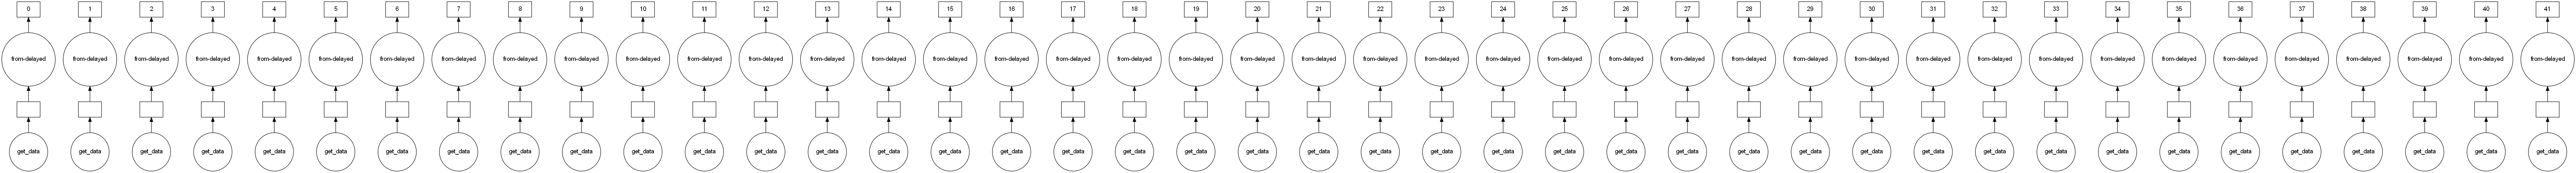

In [14]:
data_dask.visualize()

In [18]:
data_dask.compute()

no       annd      mdate  r405_A  coid  r405_Q  r405_TTM
0    001 2017-07-31 2017-06-01   33.74  1215     NaN     48.90
1    001 2021-03-23 2020-12-01  -10.06  1215     NaN    -10.06
2    001 2021-05-11 2021-03-01   65.46  1215     NaN     -0.74
3    001 2021-08-09 2021-06-01   10.69  1215     NaN     -8.11
4    001 2021-11-08 2021-09-01  -14.72  1215     NaN    -30.28
..   ...        ...        ...     ...   ...     ...       ...
99   001 2022-03-22 2021-12-01  -81.98  9950 -135.65    -81.98
100  001 2022-05-11 2022-03-01    2.11  9950    2.11    -82.94
101  001 2022-11-10 2022-09-01   60.10  9950  114.18     43.82
102  001 2023-03-24 2022-12-01   63.92  9950   81.81     63.92
103  001 2023-05-11 2023-03-01  132.47  9950  132.47     82.05

[34226 rows x 7 columns]

## 測試 get_fin_auditor
- 原本的方法
- 使用 dask 進行優化<br>
結論: dask比較快


In [81]:
default_start = '2013-01-01'
default_end = datetime.datetime.now().date().strftime('%Y-%m-%d')

# get fin data
def get_data(table, tickers, columns, start, end, fin_type):
    # 自動補上 coid, mdate
    columns += ['coid', 'mdate','key3','no','annd']
    columns = list(set(columns))
    
    data_sets = tejapi.get(table,
                            coid = tickers,
                            paginate = True,
                            chinese_column_name=False,
                            mdate = {'gte':start,'lte':end},
                            opts= {'pivot':True, 'sort':{'coid.desc', 'mdate.asc', 'key3.asc', 'no.asc'}})
        
    if len(data_sets) < 1:
        return pd.DataFrame({'coid': pd.Series(dtype='object'),
                                'mdate': pd.Series(dtype='datetime64[ns]'),
                                'key3': pd.Series(dtype='object'),
                                'no': pd.Series(dtype='object')
                                })
    
    # modify the name of the columns from upper case to lower case.
    lower_columns = {i:i.lower() for i in data_sets.columns}
    data_sets = data_sets.rename(columns=lower_columns)

    # select certain fin_type
    data_sets = get_certain_fin_type(data_sets, fin_type)

    # get most recent announce date of the company
    fin_date = get_announce_date(tickers, start = start, end = end)
    fin_date = get_certain_fin_type(fin_date, fin_type)
    data_sets = fin_date.merge(data_sets, how = 'left', on = ['coid', 'mdate', 'key3','no'])
    del fin_date
    gc.collect()
    
    # select columns
    try:
        data_sets = data_sets.loc[:,columns]
    
    except:
            # Check selected columns exist in the columns of dataframe
        selected_columns = []
        for i in columns:
            if i in data_sets.columns:
                selected_columns.append(i)
        
        # Drop duplicates
        selected_columns = list(set(selected_columns))
        
        # Select columns again
        data_sets = data_sets.loc[:,selected_columns]

    # parallel fin_type to columns 
    data_sets = fin_pivot(data_sets, remain_keys=['coid','mdate','no','annd'])
    
    # Cut off the duplicate rows
    data_sets = data_sets.sort_values(['coid','mdate', 'annd'])
    data_sets = data_sets.drop_duplicates(subset=['coid', 'annd'], keep = 'last')
    
    return data_sets

def get_fin_auditor_dask(table, tickers, columns=[], **kwargs):
    # Setting defualt value of the parameters
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    fin_type = kwargs.get('fin_type', ['A', 'Q', 'TTM'])
    npartitions = kwargs.get('npartitions', 12)


    # 自動補上 coid, mdate
    columns += ['coid', 'mdate','key3','no','annd']
    columns = list(set(columns))

    # get fin data
    def _get_data(table, tickers, columns, start, end, fin_type):
        data_sets = tejapi.get(table,
                            coid = tickers,
                            paginate = True,
                            chinese_column_name=False,
                            mdate = {'gte':start,'lte':end},
                            opts= {'pivot':True, 'sort':{'coid.desc', 'mdate.asc', 'key3.asc', 'no.asc'}})
        
        if len(data_sets) < 1:
            return pd.DataFrame({'coid': pd.Series(dtype='object'),
                                  'mdate': pd.Series(dtype='datetime64[ns]'),
                                  'key3': pd.Series(dtype='object'),
                                  'no': pd.Series(dtype='object')
                                    })
        
        # modify the name of the columns from upper case to lower case.
        lower_columns = {i:i.lower() for i in data_sets.columns}
        data_sets = data_sets.rename(columns=lower_columns)

        # select certain fin_type
        data_sets = get_certain_fin_type(data_sets, fin_type)

        # get most recent announce date of the company
        fin_date = get_announce_date(tickers, start = start, end = end)
        fin_date = get_certain_fin_type(fin_date, fin_type)
        data_sets = fin_date.merge(data_sets, how = 'left', on = ['coid', 'mdate', 'key3','no'])
        del fin_date
        gc.collect()
        
        # select columns
        try:
            data_sets = data_sets.loc[:,columns]
        
        except:
             # Check selected columns exist in the columns of dataframe
            selected_columns = []
            for i in columns:
                if i in data_sets.columns:
                    selected_columns.append(i)
            
            # Drop duplicates
            selected_columns = list(set(selected_columns))
            
            # Select columns again
            data_sets = data_sets.loc[:,selected_columns]

        # parallel fin_type to columns 
        data_sets = fin_pivot(data_sets, remain_keys=['coid','mdate','no','annd'])
        
        # Cut off the duplicate rows
        data_sets = data_sets.sort_values(['coid','mdate', 'annd'])
        data_sets = data_sets.drop_duplicates(subset=['coid', 'annd'], keep = 'last')
        
        return data_sets
    
    # Define the meta of the dataframe
    meta = _get_data(table = table, tickers = '2330', columns = columns, start = start, end =end, fin_type= fin_type)

    # 
    ticker_partitions = para.dask_mpf.get_partition_group(tickers=tickers, npartitions=npartitions)
    
    # Submit jobs to the parallel cores
    # data_sets = dd.from_delayed([dask.delayed(_get_data)(table=table, tickers = tickers[(i-1)*npartitions:i*npartitions], columns = columns, start = start, end = end, fin_type = fin_type) for i in range(1, ticker_partitions)])
    data_sets = dd.from_delayed([dask.delayed(_get_data)(table=table, tickers = tickers[(i-1)*npartitions:i*npartitions]+['2330'], columns = columns, start = start, end = end, fin_type = fin_type) for i in range(1, ticker_partitions)], meta = meta)
    
    # If ticker smaller than defaulted partitions, then transform it into defaulted partitions
    if data_sets.npartitions < npartitions:
        data_sets = data_sets.repartition(npartitions=npartitions)
    
    data_sets = data_sets.drop_duplicates(subset=['coid', 'annd'], keep = 'last')

    return data_sets

def get_fin_auditor_org(table, tickers, columns=[], **kwargs):
    # Setting defualt value of the parameters
    start = kwargs.get('start', '2013-01-01')
    end = kwargs.get('end', datetime.datetime.now().date().strftime('%Y-%m-%d'))
    fin_type = kwargs.get('fin_type', ['A', 'Q', 'TTM'])
    npartitions = kwargs.get('npartitions', 12)

    # 自動補上 coid, mdate
    columns += ['coid', 'mdate','key3','no','annd']
    columns = list(set(columns))

    # get fin data
    data_sets = tejapi.get(table,
                        coid = tickers,
                        paginate = True,
                        chinese_column_name=False,
                        mdate = {'gte':start,'lte':end},
                        opts= {'pivot':True, 'sort':{'coid.desc', 'mdate.asc', 'key3.asc', 'no.asc'}})
    
    
    # modify the name of the columns from upper case to lower case.
    lower_columns = {i:i.lower() for i in data_sets.columns}
    data_sets = data_sets.rename(columns=lower_columns)

    # select certain fin_type
    data_sets = get_certain_fin_type(data_sets, fin_type)

    # get most recent announce date of the company
    fin_date = get_announce_date(tickers, start = start, end = end)
    fin_date = get_certain_fin_type(fin_date, fin_type)
    data_sets = fin_date.merge(data_sets, how = 'left', on = ['coid', 'mdate', 'key3','no'])
    del fin_date
    gc.collect()

    # select columns
    try:
        data_sets = data_sets.loc[:,columns]
    
    except:
        # Check selected columns exist in the columns of dataframe
        selected_columns = []
        for i in columns:
            if i in data_sets.columns:
                selected_columns.append(i)
        
        # Drop duplicates
        selected_columns = list(set(selected_columns))
        
        # Select columns again
        data_sets = data_sets.loc[:,selected_columns]


    # parallel fin_type to columns 
    data_sets = fin_pivot(data_sets, remain_keys=['coid','mdate','no','annd'])
    

    # Cut off the duplicate rows
    data_sets = data_sets.sort_values(['coid','mdate', 'annd'])
    data_sets = data_sets.drop_duplicates(subset=['coid', 'annd'], keep = 'last')

    return data_sets


def get_announce_date(tickers, **kwargs):
    start = kwargs.get('start', default_start)
    end = kwargs.get('end', default_end)
    data = tejapi.get('TWN/AINVFINQA',
                    coid = tickers,
                    paginate = True,
                    chinese_column_name=False, 
                    mdate = {'gte':start, 'lte':end},
                    opts = {'sort':{'coid.asc', 'mdate.asc', 'annd.asc'}})
    return data

def get_certain_fin_type(data, fin_type):
    if type(fin_type) is str:
        # data = data.query(f'key3 == "{fin_type}"')
        data = data.loc[data['key3']==fin_type,:]

    else:
        # data = data.query(f'key3.isin({fin_type})')
        data = data.loc[data['key3'].isin(fin_type),:]
    
    return data

def fin_pivot(df, remain_keys):
     
    # for loop execute pviot function
    uni = df['key3'].dropna().unique()        
    data = pivot(df, remain_keys, uni[0])

    for i in range(1, len(uni)):
        temp = pivot(df, remain_keys, uni[i])
        data = data.merge(temp, on = remain_keys)

    return data


def pivot(df, remain_keys, pattern):
    try:
        data = df.loc[df['key3']==pattern, :]
        # Create a mapping table of column names and their corresponding new names.
        new_keys = {i:i+'_'+str(pattern) for i in data.columns.difference(remain_keys)}
        
        # Replace old names with the new ones.
        data = data.rename(columns = new_keys)
        data = data.loc[:,~data.columns.str.contains('key3')]
    
    except:
        raise ValueError('請使用 get_announce_date 檢查該檔股票的財務數據發布日是否為空值。')
    
    return data

In [77]:
all_columns = para.table_columns['COLUMNS'].unique().tolist()
tickers = pd.read_csv('./tables/mktboard.csv')
all_tickers = tickers[tickers.mkt_board.isin(['TSE'])]['stk_id'].unique().tolist()
all_fin_auditor = para.table_columns.query('TABLE_NAMES == "fin_auditor"')['COLUMNS'].unique().tolist()

In [52]:
meta = get_data(table = 'TWN/AINVFINQ', tickers = '2330', columns = all_fin_auditor, start = '2022-01-01', end = '2023-01-01', fin_type = ['A', 'Q', 'TTM'])

In [90]:
meta

r408_A       annd    if31_A  bp61_A      cv41_A        bstl_A  r403_A  \
0   36.78 2022-05-13  140399.0     0.0   -349376.0  1.671208e+09   48.66   
4   36.78 2023-05-12  140399.0     0.0   -349376.0  1.671208e+09   48.66   
1   40.52 2022-08-12  293334.0     0.0     -8906.0  1.835479e+09   64.05   
2   39.34 2022-11-14  395961.0     0.0   5976065.0  1.890986e+09   70.42   
3   33.26 2023-02-24  370266.0     0.0  19598313.0  2.004290e+09   72.51   

   r404_A      bp96_A     cbp41_A  ...  bv21_TTM  bv11_TTM  bf31_TTM  \
0   46.28  10333155.0   1381290.0  ...       NaN       NaN       NaN   
4   46.28  10333155.0   1381290.0  ...       NaN       NaN       NaN   
1   61.87  13341271.0  11095277.0  ...       NaN       NaN       NaN   
2   69.25  10552495.0  13295435.0  ...       NaN       NaN       NaN   
3   72.54  12888776.0   7799556.0  ...       NaN       NaN       NaN   

      cscfi_TTM  bf99_TTM  bsncl_TTM  cf31_TTM     nri_TTM  cbp62_TTM  \
0 -8.801882e+08       NaN        NaN       0.0  -4849360.0    -5574.0   
4 -8.801882e+08       NaN        NaN       0.0  -4849360.0    -5574.0   
1 -9.863693e+08       NaN        NaN       0.0 -12955680.0    -8339.0   
2 -1.093740e+09       NaN        NaN       0.0  -5613076.0    -3053.0   
3 -1.190928e+09       NaN        NaN       0.0   -765846.0    -7444.0   

     cip31_TTM  
0  432596614.0  
4  432596614.0  
1  442016103.0  
2  440335006.0  
3  437254273.0  

[5 rows x 487 columns]

In [82]:
data = get_fin_auditor_dask(table = 'TWN/AINVFINQ', tickers = all_tickers, columns = all_fin_auditor, start = '2022-01-01', end = '2023-01-01', fin_type = ['A', 'Q', 'TTM'])

In [91]:
data.visualize()

In [83]:
data_dask = data.compute()

In [87]:
data_dask.sort_values(['coid','mdate','annd'])

r408_A       annd     if31_A     bp61_A     cv41_A       bstl_A  r403_A  \
0    16.09 2022-05-10  -347638.0  5472861.0   129947.0  217080516.0  -95.07   
4    16.09 2023-05-11  -347638.0  5472861.0   129947.0  217080516.0  -95.07   
1    16.62 2022-08-12 -1492399.0  5087475.0  2022851.0  233315278.0 -116.00   
2    14.29 2022-11-10 -1363448.0  4705273.0  2592357.0  237063153.0 -107.76   
3     4.33 2023-02-24 -1247899.0  4268024.0  3209321.0  222533181.0  -94.13   
..     ...        ...        ...        ...        ...          ...     ...   
60   60.43 2022-05-13    63643.0        0.0   108576.0   19160392.0   13.83   
65   59.64 2023-05-15    63643.0        0.0   108576.0   19175899.0   10.26   
62   33.96 2022-08-15   -15108.0        0.0   114768.0   19011672.0  -62.33   
63   23.26 2022-11-11   -32260.0        0.0   130244.0   21363413.0  -73.09   
64    9.26 2023-03-31  -268503.0        0.0   138762.0   19119083.0  -94.71   

    r404_A     bp96_A    cbp41_A  ...  bv21_TTM  bv11_TTM  bf31_TTM  \
0   -75.86   817729.0   885579.0  ...       NaN       NaN       NaN   
4   -75.86   718750.0   885579.0  ...       NaN       NaN       NaN   
1   -94.97   987913.0  3105124.0  ...       NaN       NaN       NaN   
2   -85.32  1087386.0  3485449.0  ...       NaN       NaN       NaN   
3   -74.51   535649.0  3565856.0  ...       NaN       NaN       NaN   
..     ...        ...        ...  ...       ...       ...       ...   
60   26.99   442403.0  -159329.0  ...       NaN       NaN       NaN   
65   23.30   442403.0  -159329.0  ...       NaN       NaN       NaN   
62  -56.38   472234.0   -68219.0  ...       NaN       NaN       NaN   
63  -62.19   680614.0  1146833.0  ...       NaN       NaN       NaN   
64  -91.33   616818.0  1260932.0  ...       NaN       NaN       NaN   

     cscfi_TTM  bf99_TTM  bsncl_TTM    cf31_TTM    nri_TTM  cbp62_TTM  \
0  -17901040.0       NaN        NaN   1392274.0  2530960.0  -677305.0   
4  -17901040.0       NaN        NaN         0.0  2543029.0  -677305.0   
1  -21763853.0       NaN        NaN   1392274.0  2039971.0 -1359509.0   
2  -19454129.0       NaN        NaN   1392274.0  2394731.0  -257331.0   
3  -16590037.0       NaN        NaN  13393957.0  2397093.0  -191549.0   
..         ...       ...        ...         ...        ...        ...   
60  -5069314.0       NaN        NaN         0.0   219393.0    -5016.0   
65  -5069314.0       NaN        NaN         0.0   221495.0    -5016.0   
62  -4214544.0       NaN        NaN         0.0    49780.0   -16402.0   
63  -3252845.0       NaN        NaN         0.0    49893.0   -13877.0   
64  -2615584.0       NaN        NaN         0.0    51121.0    -8969.0   

    cip31_TTM  
0   7185218.0  
4   7185218.0  
1   7680825.0  
2   7809820.0  
3   8516035.0  
..        ...  
60   411606.0  
65   411443.0  
62   443616.0  
63   488235.0  
64   586095.0  

[4987 rows x 487 columns]

In [89]:
data_dask.query('coid == "2330"')

r408_A       annd    if31_A  bp61_A      cv41_A        bstl_A  r403_A  \
5   36.78 2022-05-13  140399.0     0.0   -349376.0  1.671208e+09   48.66   
9   36.78 2023-05-12  140399.0     0.0   -349376.0  1.671208e+09   48.66   
6   40.52 2022-08-12  293334.0     0.0     -8906.0  1.835479e+09   64.05   
7   39.34 2022-11-14  395961.0     0.0   5976065.0  1.890986e+09   70.42   
8   33.26 2023-02-24  370266.0     0.0  19598313.0  2.004290e+09   72.51   

   r404_A      bp96_A     cbp41_A  ...  bv21_TTM  bv11_TTM  bf31_TTM  \
5   46.28  10333155.0   1381290.0  ...       NaN       NaN       NaN   
9   46.28  10333155.0   1381290.0  ...       NaN       NaN       NaN   
6   61.87  13341271.0  11095277.0  ...       NaN       NaN       NaN   
7   69.25  10552495.0  13295435.0  ...       NaN       NaN       NaN   
8   72.54  12888776.0   7799556.0  ...       NaN       NaN       NaN   

      cscfi_TTM  bf99_TTM  bsncl_TTM  cf31_TTM     nri_TTM  cbp62_TTM  \
5 -8.801882e+08       NaN        NaN       0.0  -4849360.0    -5574.0   
9 -8.801882e+08       NaN        NaN       0.0  -4849360.0    -5574.0   
6 -9.863693e+08       NaN        NaN       0.0 -12955680.0    -8339.0   
7 -1.093740e+09       NaN        NaN       0.0  -5613076.0    -3053.0   
8 -1.190928e+09       NaN        NaN       0.0   -765846.0    -7444.0   

     cip31_TTM  
5  432596614.0  
9  432596614.0  
6  442016103.0  
7  440335006.0  
8  437254273.0  

[5 rows x 487 columns]

In [85]:
data_org = get_fin_auditor_org(table = 'TWN/AINVFINQ', tickers= all_tickers, columns=all_fin_auditor, start = '2022-01-01', end = '2023-01-01', fin_type = ['A', 'Q', 'TTM'])

In [88]:
data_org.sort_values(['coid','mdate','annd'])

r408_A       annd     if31_A     bp61_A     cv41_A       bstl_A  r403_A  \
0      16.09 2022-05-10  -347638.0  5472861.0   129947.0  217080516.0  -95.07   
4      16.09 2023-05-11  -347638.0  5472861.0   129947.0  217080516.0  -95.07   
1      16.62 2022-08-12 -1492399.0  5087475.0  2022851.0  233315278.0 -116.00   
2      14.29 2022-11-10 -1363448.0  4705273.0  2592357.0  237063153.0 -107.76   
3       4.33 2023-02-24 -1247899.0  4268024.0  3209321.0  222533181.0  -94.13   
...      ...        ...        ...        ...        ...          ...     ...   
4989   60.43 2022-05-13    63643.0        0.0   108576.0   19160392.0   13.83   
4994   59.64 2023-05-15    63643.0        0.0   108576.0   19175899.0   10.26   
4991   33.96 2022-08-15   -15108.0        0.0   114768.0   19011672.0  -62.33   
4992   23.26 2022-11-11   -32260.0        0.0   130244.0   21363413.0  -73.09   
4993    9.26 2023-03-31  -268503.0        0.0   138762.0   19119083.0  -94.71   

      r404_A     bp96_A    cbp41_A  ...  bv21_TTM  bv11_TTM  bf31_TTM  \
0     -75.86   817729.0   885579.0  ...       NaN       NaN       NaN   
4     -75.86   718750.0   885579.0  ...       NaN       NaN       NaN   
1     -94.97   987913.0  3105124.0  ...       NaN       NaN       NaN   
2     -85.32  1087386.0  3485449.0  ...       NaN       NaN       NaN   
3     -74.51   535649.0  3565856.0  ...       NaN       NaN       NaN   
...      ...        ...        ...  ...       ...       ...       ...   
4989   26.99   442403.0  -159329.0  ...       NaN       NaN       NaN   
4994   23.30   442403.0  -159329.0  ...       NaN       NaN       NaN   
4991  -56.38   472234.0   -68219.0  ...       NaN       NaN       NaN   
4992  -62.19   680614.0  1146833.0  ...       NaN       NaN       NaN   
4993  -91.33   616818.0  1260932.0  ...       NaN       NaN       NaN   

       cscfi_TTM  bf99_TTM  bsncl_TTM    cf31_TTM    nri_TTM  cbp62_TTM  \
0    -17901040.0       NaN        NaN   1392274.0  2530960.0  -677305.0   
4    -17901040.0       NaN        NaN         0.0  2543029.0  -677305.0   
1    -21763853.0       NaN        NaN   1392274.0  2039971.0 -1359509.0   
2    -19454129.0       NaN        NaN   1392274.0  2394731.0  -257331.0   
3    -16590037.0       NaN        NaN  13393957.0  2397093.0  -191549.0   
...          ...       ...        ...         ...        ...        ...   
4989  -5069314.0       NaN        NaN         0.0   219393.0    -5016.0   
4994  -5069314.0       NaN        NaN         0.0   221495.0    -5016.0   
4991  -4214544.0       NaN        NaN         0.0    49780.0   -16402.0   
4992  -3252845.0       NaN        NaN         0.0    49893.0   -13877.0   
4993  -2615584.0       NaN        NaN         0.0    51121.0    -8969.0   

      cip31_TTM  
0     7185218.0  
4     7185218.0  
1     7680825.0  
2     7809820.0  
3     8516035.0  
...         ...  
4989   411606.0  
4994   411443.0  
4991   443616.0  
4992   488235.0  
4993   586095.0  

[4987 rows x 487 columns]

In [45]:
data_dask = get_fin_auditor_dask(table = 'TWN/AINVFINQ', tickers= all_tickers[:500], columns=['r405'],start = '2008-01-01')

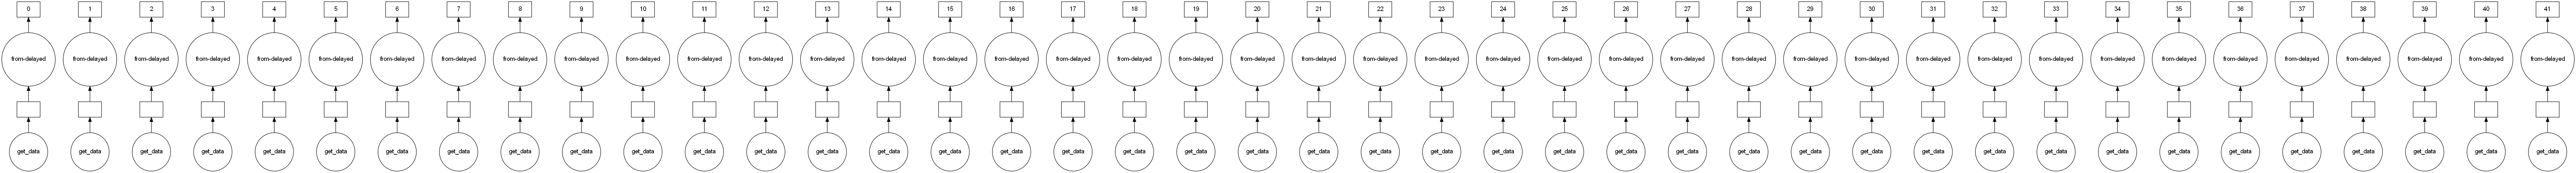

In [46]:
data_dask.visualize()

In [47]:
data_dask.compute()

mdate  coid   no       annd  r405_A  r405_Q  r405_TTM
0   2008-03-01  1101  001 2008-04-28  -10.87  -10.87       NaN
12  2008-06-01  1101  001 2008-08-27  -15.44  -18.18       NaN
24  2008-09-01  1101  001 2008-10-29  -19.16  -29.15       NaN
36  2008-12-01  1101  001 2009-04-29  -41.97  -80.50       NaN
48  2009-03-01  1101  001 2009-05-15  -71.51  -71.51       NaN
..         ...   ...  ...        ...     ...     ...       ...
607 2022-03-01  2637  001 2022-04-29  200.90  200.90       NaN
616 2022-06-01  2637  001 2022-08-19  182.76  172.43       NaN
624 2022-09-01  2637  001 2022-10-28   85.00   -4.67       NaN
632 2022-12-01  2637  001 2023-02-24   28.19  -65.31       NaN
640 2023-03-01  2637  001 2023-05-12 -104.99 -104.99       NaN

[26860 rows x 7 columns]